In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks/libs
%ls
!pip install import_ipynb
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install rdkit
!pip install PyTDC

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/libs
 CNN_test.png     layers.ipynb    'pdbbind_v2019_refined.tar.gz?download=1'
 data/            Model.ipynb      seq.csv
 io_utils.ipynb   model_test.png   utils.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 MB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 20.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 3.7 MB/

In [ ]:
!pip install subword_nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
import torch
import dgl
import pandas as pd
import numpy as np

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# 데이터 준비하기

## 데이터 불러오기

In [ ]:
from tdc.multi_pred import DTI
data_DA = DTI(name = 'DAVIS')
split_DA = data_DA.get_split(frac=[1.0,0,0])
data_KI = DTI(name = 'KIBA')
split_KI = data_KI.get_split(frac=[1.0,0,0])
data_BD = DTI(name = 'BindingDB_Kd')
data_BD.harmonize_affinities(mode = 'max_affinity')
split_BD = data_BD.get_split(frac=[1.0,0,0])

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
The scale is in original affinity scale, so we will take the minimum!
The original data has been updated!


In [ ]:
print(split_DA['train'])
print(split_KI['train'])
print(split_BD['train'])

        Drug_ID                                           Drug Target_ID  \
0      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      AAK1   
1      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ABL1p   
2      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      ABL2   
3      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ACVR1   
4      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12    ACVR1B   
...         ...                                            ...       ...   
25767    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       YES   
25768    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK1   
25769    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK4   
25770    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       ZAK   
25771    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1     ZAP70   

                                                  Target        Y  
0      MKKFFDSRREQG

In [ ]:
# Binding affinity cutoff로 affinity 이진화(binary)하기

threshold = 300

split_DA['train']['y'] = [1 if i else 0 for i in np.array(split_DA['train']['Y']) < threshold]
split_KI['train']['y'] = [1 if i else 0 for i in np.array(split_KI['train']['Y']) < threshold]
split_BD['train']['y'] = [1 if i else 0 for i in np.array(split_BD['train']['Y']) < threshold]

In [ ]:
df_DA = split_DA['train']
df_KI=split_KI['train']
df_BD = split_BD['train']

## 데이터 프레임

In [ ]:

# Label 비율 확인

import seaborn as sns
import matplotlib.pyplot as plt

counts = df_DA['y'].value_counts() # label counts
print(counts)
counts = df_KI['y'].value_counts() # label counts
print(counts)
counts = df_BD['y'].value_counts() # label counts
print(counts)

0    22996
1     2776
Name: y, dtype: int64
1    117657
Name: y, dtype: int64
0    31698
1    10538
Name: y, dtype: int64


In [ ]:
df_BD_1=df_BD.query('y==1')
df = pd.concat([df_DA, df_BD_1])
df

,Drug_ID,Drug,Target_ID,Target,Y,y
0,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,43.0,1
1,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,10000.0,0
2,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,10000.0,0
3,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,10000.0,0
4,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1B,MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...,10000.0,0
...,...,...,...,...,...,...
42229,138805905.0,COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,52.0,1
42230,138805906.0,COc1nc2ccc([C@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3C...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,55.0,1
42231,138805907.0,COc1nc2ccc([C@@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.1,1
42233,138805909.0,COc1nc2ccc([C@@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.5,1


## 중복값 제거

In [ ]:
df_drop=df.drop_duplicates(subset=['Drug','Target'])
df=df_drop
df

,Drug_ID,Drug,Target_ID,Target,Y,y
0,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,43.0,1
1,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,10000.0,0
2,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,10000.0,0
3,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,10000.0,0
4,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1B,MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...,10000.0,0
...,...,...,...,...,...,...
42229,138805905.0,COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,52.0,1
42230,138805906.0,COc1nc2ccc([C@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3C...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,55.0,1
42231,138805907.0,COc1nc2ccc([C@@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.1,1
42233,138805909.0,COc1nc2ccc([C@@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.5,1


Text(0, 0.5, 'Counts')

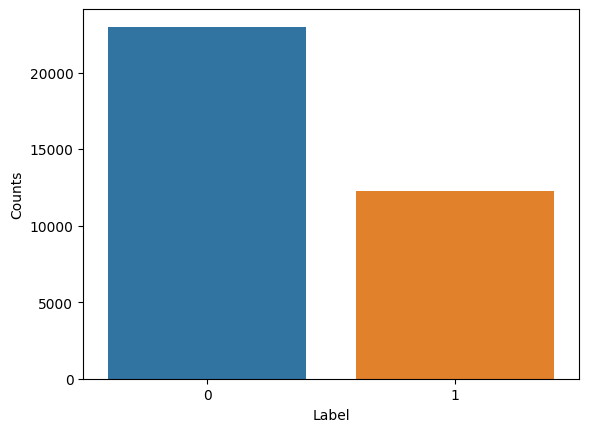

In [ ]:
counts = df['y'].value_counts()

x = np.array([0,1])

ax = plt.subplot()
sns.barplot(x=x,y=counts)

plt.xlabel("Label")
plt.ylabel("Counts")

# protein preprocessing

## protein mol2vec dict 만들기
- protein_2_embed

In [ ]:
from subword_nmt.apply_bpe import BPE
import codecs

common_path='/content/drive/MyDrive/Colab_Notebooks/protein_embedding/'

vocab_path = common_path + 'protein_codes_uniprot.txt'
bpe_codes_protein = codecs.open(vocab_path)
pbpe = BPE(bpe_codes_protein, merges=-1, separator='')
sub_csv = pd.read_csv(common_path + 'subword_units_map_uniprot.csv')

idx2word_p = sub_csv['index'].values
words2idx_p = dict(zip(idx2word_p, range(2, len(idx2word_p)+2)))

# words2idx_p['<pad>'] = 0 # padding token
# words2idx_p['<unk>'] = 1 # unknown token

print(words2idx_p)
print(len(words2idx_p))

{'L': 2, 'V': 3, 'S': 4, 'W': 5, 'Q': 6, 'E': 7, 'I': 8, 'T': 9, 'Y': 10, 'G': 11, 'A': 12, 'R': 13, 'U': 14, 'M': 15, 'P': 16, 'H': 17, 'Z': 18, 'D': 19, 'F': 20, 'K': 21, 'O': 22, 'B': 23, 'C': 24, 'X': 25, 'N': 26, 'LL': 27, 'AA': 28, 'AL': 29, 'VL': 30, 'GL': 31, 'EL': 32, 'SL': 33, 'GG': 34, 'SS': 35, 'EE': 36, 'TL': 37, 'DL': 38, 'RL': 39, 'IL': 40, 'AV': 41, 'KL': 42, 'AG': 43, 'VV': 44, 'AE': 45, 'KK': 46, 'SG': 47, 'AI': 48, 'PL': 49, 'AR': 50, 'AD': 51, 'AS': 52, 'QL': 53, 'TG': 54, 'AK': 55, 'VE': 56, 'NL': 57, 'FL': 58, 'VI': 59, 'VG': 60, 'AT': 61, 'KE': 62, 'RR': 63, 'VD': 64, 'VS': 65, 'PG': 66, 'IE': 67, 'PE': 68, 'IG': 69, 'ID': 70, 'VT': 71, 'RE': 72, 'IS': 73, 'AQ': 74, 'DG': 75, 'VK': 76, 'DE': 77, 'PS': 78, 'YL': 79, 'RG': 80, 'IT': 81, 'AF': 82, 'NG': 83, 'KG': 84, 'AP': 85, 'VR': 86, 'TT': 87, 'IK': 88, 'FG': 89, 'SE': 90, 'AN': 91, 'VP': 92, 'HL': 93, 'IN': 94, 'ML': 95, 'IR': 96, 'TS': 97, 'TE': 98, 'VN': 99, 'QQ': 100, 'FS': 101, 'DD': 102, 'IP': 103, 'FE': 10

In [ ]:
def protein_tokenizer(x):
  prot_token=pbpe.process_line(x).split()
  return prot_token

In [ ]:
from gensim.models import word2vec
from rdkit.Chem import AllChem

model = word2vec.Word2Vec.load('/content/drive/MyDrive/Colab_Notebooks/protein_embedding/model_300dim.pkl')

aard /sg/ aa/ mad

아미노산 mol

In [ ]:
def mol2alt_sentence(mol, radius):

    radii = list(range(int(radius) + 1))
    info = {}
    _ = AllChem.GetMorganFingerprint(mol, radius, bitInfo=info)  # info: dictionary identifier, atom_idx, radius

    mol_atoms = [a.GetIdx() for a in mol.GetAtoms()]
    dict_atoms = {x: {r: None for r in radii} for x in mol_atoms}

    for element in info:
        for atom_idx, radius_at in info[element]:
            dict_atoms[atom_idx][radius_at] = element  # {atom number: {fp radius: identifier}}

    # merge identifiers alternating radius to sentence: atom 0 radius0, atom 0 radius 1, etc.
    identifiers_alt = []
    for atom in dict_atoms:  # iterate over atoms
        for r in radii:  # iterate over radii
            identifiers_alt.append(dict_atoms[atom][r])

    alternating_sentence = map(str, [x for x in identifiers_alt if x])

    return list(alternating_sentence)

In [ ]:
All_bpe_prot=list(words2idx_p.keys())

def prot2mol(All_bpe_prot):
  prot_mol_dict={}
  for prot in All_bpe_prot:
    try:
      prot_mol=rdkit.Chem.rdmolfiles.MolFromSequence(prot)
      if prot_mol == None:
        continue
      else:
        prot_mol_dict[prot]=prot_mol
    except:
      continue
  return prot_mol_dict

prot_mol_dict=prot2mol(All_bpe_prot)
print(prot_mol_dict)

{'L': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd070>, 'V': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd0e0>, 'S': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd150>, 'W': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd1c0>, 'Q': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd230>, 'E': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd2a0>, 'I': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd310>, 'T': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd380>, 'Y': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd3f0>, 'G': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd460>, 'A': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd4d0>, 'R': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd540>, 'M': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd5b0>, 'P': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd620>, 'H': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd690>, 'D': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd700>, 'F': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd770>, 'K': <rdkit.Chem.rdchem.Mol object at 0x7fb3d1bdd7e0>, 'C': <rdk

In [ ]:
prot_identi_dict={}
for key,mol in prot_mol_dict.items():
  if mol==None:
    continue
  else:
    prot_identi_dict[key]=mol2alt_sentence(mol,1)
aa_sentences=list(prot_identi_dict.values())
flat_list = [item for sublist in aa_sentences for item in sublist]
aa_identifiers_unique = set(flat_list)

In [ ]:
df_vec = pd.DataFrame()
df_vec['identifier'] = list(aa_identifiers_unique)
df_vec.index = df_vec['identifier']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca_model = PCA(n_components=30)
tsne_model = TSNE(n_components=3, perplexity=10, n_iter=1000, metric = 'cosine')
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform([model.wv.word_vec(x) for x in aa_identifiers_unique]))

In [ ]:
df_vec['PCA-t-SNE-c1'] = tsne_pca.T[0]
df_vec['PCA-t-SNE-c2'] = tsne_pca.T[1]
df_vec['PCA-t-SNE-c3']= tsne_pca.T[2]

In [ ]:
df_vec

,identifier,PCA-t-SNE-c1,PCA-t-SNE-c2,PCA-t-SNE-c3
identifier,,,,
2968968094,2968968094,-6.510602,83.952789,8.571500
443932914,443932914,32.950432,75.862724,-66.058098
2245384272,2245384272,-39.826580,-27.707260,10.767040
1542633699,1542633699,45.632301,-71.701347,80.367554
98513984,98513984,4.465590,3.231552,65.469337
...,...,...,...,...
2655406212,2655406212,33.405952,-102.519562,29.139467
4121755354,4121755354,0.617893,62.750782,88.191177
787341104,787341104,-5.589835,-0.701830,-101.746193


In [ ]:
df_vec # protein을 token화 시켰을 때의 값.
projections = df_vec.to_dict()

vector를 얻어냈을 때 normalize해줌

In [ ]:
def get_values(identifier, projections):
  A=np.array((projections['PCA-t-SNE-c1'][str(identifier)],projections['PCA-t-SNE-c2'][str(identifier)],projections['PCA-t-SNE-c3'][str(identifier)]))
  return A/np.linalg.norm(A)

def prot2emb(protein_list):
  prot_emb_list=[]
  for aa in protein_list:
    aa_values = np.sum(np.array([get_values(x, projections) for x in prot_identi_dict[aa]]),axis=0)
    prot_emb_list.append(aa_values)
  return np.array(prot_emb_list)

# protein data 중 오류값 df에서 제거

In [ ]:
MAX_SEQ_PROTEIN=200 # BPE로 끊었을때 max seq

def get_prot_vector(prot):
  temp=protein_tokenizer(prot)

  temp=prot2emb(temp)

  if len(temp) < MAX_SEQ_PROTEIN:
    num=MAX_SEQ_PROTEIN-len(temp)
    arr=np.zeros((num,3))
    temp=np.concatenate((temp,arr),axis=0)
  else:
    temp = temp[:MAX_SEQ_PROTEIN]

  return temp

## df index rearrangement

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,Drug_ID,Drug,Target_ID,Target,Y,y
0,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,43.0,1
1,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,10000.0,0
2,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,10000.0,0
3,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,10000.0,0
4,11314340.0,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1B,MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...,10000.0,0
...,...,...,...,...,...,...
35244,138805905.0,COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,52.0,1
35245,138805906.0,COc1nc2ccc([C@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3C...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,55.0,1
35246,138805907.0,COc1nc2ccc([C@@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.1,1
35247,138805909.0,COc1nc2ccc([C@@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.5,1


In [ ]:
A=df.query("Target == 'LKMNKLPSNRGNTLREVQLMNRLRHPNILRFMGVCVHQGQLHALTEYMNGGTLEXLLSSPEPLSWPVRLHLALDIARGLRYLHSKGVFHRDLTSKNCLVRREDRGFTAVVGDFGLAEKIPVYREGARKEPLAVVGSPYWMAPEVLRGELYDEKADVFAFGIVLCELIARVPADPDYLPRTEDFGLDVPAFRTLVGDDCPLPFLLLAIHCCNLEPSTRAPFTEITQHLEWILEQLPEPAPLTXTA'")
fxxklist=[A.index]
dropnum=[]
for l in fxxklist:
  for num in l:
    dropnum.append(num)
print(df)
df=df.drop(index=dropnum)
print(df)

           Drug_ID                                               Drug  \
0       11314340.0      Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12   
1       11314340.0      Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12   
2       11314340.0      Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12   
3       11314340.0      Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12   
4       11314340.0      Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12   
...            ...                                                ...   
35244  138805905.0  COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...   
35245  138805906.0  COc1nc2ccc([C@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3C...   
35246  138805907.0  COc1nc2ccc([C@@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3...   
35247  138805909.0  COc1nc2ccc([C@@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3...   
35248  138805911.0  COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...   

      Target_ID                                             Target        Y  y  
0          AAK1  MKKFFDSRREQGGSGLGSGSSGGGG

# sample 7000개

In [ ]:
df_1 = pd.DataFrame(df.query('y==1'))
print('df_1',len(df_1))
df_1 = df_1.sample(n=3500, random_state=999) # random_state를 설정하면 출력 결과 항상 동일해짐
df_0 = pd.DataFrame(df.query('y==0'))
print('df-0',len(df_0))
df_0 = df_0.sample(n=3500, random_state=999)
df_sample = pd.concat([df_1, df_0])
df_sample

df_1 12249
df-0 22932


,Drug_ID,Drug,Target_ID,Target,Y,y
26544,126565.0,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4c(c5c6...,P54646,MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...,56.00,1
31236,44356858.0,NC(N)=Nc1ccc(C2CC(=O)O/C(=C\I)C2)cc1,P00760,MKTFIFLALLGAAVAFPVDDDDKIVGGYTCGANTVPYQVSLNSGYH...,0.02,1
32784,70681477.0,C[C@@H]1NC(=O)[C@H](Cc2cccs2)NC(=O)CCCNC(=O)[C...,Q28642,MLNITSQVLAPALNGSVSQSSGCPNTEWSGWLNVIQAPFLWVLFVL...,63.10,1
31556,44430130.0,N#C[C@H](CCc1ccccc1)NC(=O)[C@@H](CC(=O)N1CCOCC...,P25774,MKRLVCVLLVCSSAVAQLHKDPTLDHHWHLWKKTYGKQYKEKNEEA...,25.00,1
33533,91896047.0,CC(COc1nccc(-c2nc(-c3ccncc3)c(-c3ccc4c(c3)CCC4...,P15056,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,0.50,1
...,...,...,...,...,...,...
25310,9809715.0,COC(=O)c1ccc2c(c1)NC(=O)C2=C(Nc1ccc(N(C)C(=O)C...,PRKX,MEAPGLAQAAAAESDSRKVAEETPDGAPALCPSPEALSPEPPVYSL...,10000.00,0
1974,5287969.0,CN1CCC(c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)C...,CTK,MAGRGSLVSWRAFHGCDSAEELPRVSPRFLRAWHPPPVSARMPTRR...,10000.00,0
11144,11427553.0,O=C(c1ccc(C=Cc2n[nH]c3ccccc23)cc1)N1CCNCC1,INSR,MATGGRRGAAAAPLLVAVAALLLGAAGHLYPGEVCPGMDIRNNLTR...,400.00,0
18868,25127112.0,N#CCC(C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1.O=P(O...,PRP4,MAAAETQSLREQPEMEDANSEKSINEENGEVSEDQSQNKHSRHKKK...,10000.00,0


In [ ]:
df=df_sample

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Drug_ID,Drug,Target_ID,Target,Y,y
0,117927174.0,CCN1CCN(CCOc2cc3ncc(-c4ccc(CC(=O)Nc5cc(C6(C(F)...,P36888,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,5.0,1
1,122181481.0,C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc2...,Q13526,MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGK...,108.0,1
2,9915743.0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4ccccn4)c(Cl)c3)c2...,P51955,MPSRAEDYEVLYTIGTGSYGRCQKIRRKSDGKILVWKELDYGSMTE...,250.0,1
3,9926791.0,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,MKNK1,MVSSQKLEKPIEMGSSEPLPIADGDRRRKKKRRGRATDSLPGKFED...,10000.0,0
4,11667893.0,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21,TIE2,DDANGKSQTAGFLKGSLGPHAHLWKLDGEIWGSMDSLASLVLCGVS...,10000.0,0
...,...,...,...,...,...,...
6995,91809487.0,NS(=O)(=O)c1c(F)c(F)c(N2CCCCC2)c(F)c1F,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,1.9,1
6996,9869779.0,COc1cc(Oc2ccnc3cc(OC)c(OC)cc23)ccc1NC(=O)NC(C)...,Q96GD4,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,160.0,1
6997,5328940.0,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,TAOK3,MRKGVLKDPEIADLFYKDDPEELFIGLHEIGHGSFGAVYFATNAHT...,340.0,0
6998,9926791.0,CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12,PIP5K1A,MASASSGPSSSVGFSSFDPAVPSCTLSSAASGIKRPMASEVLEARQ...,10000.0,0


# 데이터 나누기 (Train/ Validation )

In [ ]:
def create_fold(df, fold_seed, frac):

    train_frac, val_frac, test_frac = frac

    # Test 데이터 random sampling
    test = df.sample(frac = test_frac, replace = False, random_state = fold_seed)
    train_val = df[~df.index.isin(test.index)] # Train & Validation 데이터

    # Validation 데이터 random sampling
    val = train_val.sample(frac = val_frac/(1-test_frac), replace = False, random_state = 1)
    train = train_val[~train_val.index.isin(val.index)] # Train 데이터

    return train, val, test

In [ ]:
train, val, test = create_fold(df, 22, [0.7,0.1,0.2])

In [ ]:
print(f'Train 데이터 크기: {len(train)}')
print(f'Validation 데이터 크기: {len(val)}')
print(f'Test 데이터 크기: {len(test)}')

Train 데이터 크기: 4900
Validation 데이터 크기: 700
Test 데이터 크기: 1400


## Custom Dataloader

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from torch.utils import data

- smiles - BPE-target-seq - y(label)로 return해줌

In [ ]:
class data_process_loader(Dataset):
    def __init__(self, df):

        self.df = df

    def __len__(self):
        """샘플 개수
        """
        return self.df.shape[0]

    def __getitem__(self, index):
        # Drug 데이터
        v_d = self.df.iloc[index]['Drug'] # drug SMILES

        # Target 데이터
        v_p = self.df.iloc[index]['Target']
         # Target One-hot 인코딩 [26,100]

        # Binding affinity (label)
        y = self.df.iloc[index]['y']

        return v_d, v_p, y

In [ ]:
# 디바이스 설정

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 cuda:0 입니다.


In [ ]:
train_dataset = data_process_loader(train)
valid_dataset = data_process_loader(val)
test_dataset = data_process_loader(test)

In [ ]:
# Dataset 확인 해보기

for (v_d, v_p, y) in valid_dataset:
    print(v_d)
    print(v_p)
    print(len(v_p))
    print(y)
    break

O=C(NC1CCNCC1)c1[nH]ncc1NC(=O)c1c(Cl)cccc1Cl
MTNNSGSKAELVVGGKYKLVRKIGSGSFGDVYLGITTTNGEDVAVKLESQKVKHPQLLYESKLYTILQGGVGIPHMHWYGQEKDNNVLVMDLLGPSLEDLFNFCSRRFTMKTVLMLADQMISRIEYVHTKNFLHRDIKPDNFLMGTGRHCNKLFLIDFGLAKKYRDNRTRQHIPYREDKHLIGTVRYASINAHLGIEQSRRDDMESLGYVFMYFNRTSLPWQGLRAMTKKQKYEKISEKKMSTPVEVLCKGFPAEFAMYLNYCRGLRFEEVPDYMYLRQLFRILFRTLNHQYDYTFDWTMLKQKAAQQAASSSGQGQQAQTQTGKQTEKNKNNVKDN
337
0


## Dataload / my_collate_fn

smile -> graph

In [ ]:
import torch
import dgl
ATOM_VOCAB=[
    'C','N','O','S','F',
    'H','Si','P','Cl','Br',
    'Li', 'Na', 'K ', 'Mg', 'Ca',
     'Fe', 'As', 'Al','I', 'B',
     'V', 'Tl', 'Sb','Sn','Ag',
     'Pd','Co','Se','Ti','Zn',
     'Ge','Cu','Au','Ni','Cd',
     'Mn','Cr','Pt','Hg','Pb'
]

def one_of_k_encoding(x, vocab): # one_hot_encoding of list
  if x not in vocab:
    x=vocab[-1]
  return list(map(lambda s: float(x==s), vocab))

def get_atom_feature(atom):
  atom_feature = one_of_k_encoding(atom.GetSymbol,ATOM_VOCAB)
  atom_feature += one_of_k_encoding(atom.GetDegree(),[0,1,2,3,4,5])
  atom_feature += one_of_k_encoding(atom.GetTotalNumHs(),[0,1,2,3,4])
  atom_feature += one_of_k_encoding(atom.GetImplicitValence(),[0,1,2,3,4,5])
  atom_feature += [atom.GetIsAromatic()]
  return atom_feature

def get_bond_feature(bond):
  bt=bond.GetBondType()
  bond_feature=[
      bt==Chem.rdchem.BondType.SINGLE,
      bt==Chem.rdchem.BondType.DOUBLE,
      bt==Chem.rdchem.BondType.TRIPLE,
      bt==Chem.rdchem.BondType.AROMATIC,
      bond.GetIsConjugated(),
      bond.IsInRing()]
  return bond_feature

def get_molecular_graph(smi):
  mol=Chem.MolFromSmiles(smi)

  graph=dgl.DGLGraph()

  atom_list=mol.GetAtoms()
  num_atoms=len(atom_list)
  graph.add_nodes(num_atoms)

  atom_feature_list = [get_atom_feature(atom) for atom in atom_list]
  atom_feature_list = torch.tensor(atom_feature_list, dtype=torch.float64)
  graph.ndata['h'] = atom_feature_list

  bond_list = mol.GetBonds()
  bond_feature_list=[]
  for bond in bond_list:
    bond_feature = get_bond_feature(bond)

    src=bond.GetBeginAtom().GetIdx()
    dst=bond.GetEndAtom().GetIdx()

    # DGL graph is undirectional
    # Thus, we have to add edge pair of both(i,j) and (j,i)
    # i --> j
    graph.add_edges(src, dst)
    bond_feature_list.append(bond_feature)

    # j --> i
    graph.add_edges(dst,src)
    bond_feature_list.append(bond_feature)

  bond_feature_list=torch.tensor(bond_feature_list, dtype=torch.float64)
  graph.edata['e_ij'] = bond_feature_list
  return graph


prot -> vec

In [ ]:
MAX_SEQ_PROTEIN=200 # BPE로 끊었을때 max seq

def get_prot_vector(prot):
  temp=protein_tokenizer(prot)

  temp=prot2emb(temp)

  if len(temp) < MAX_SEQ_PROTEIN:
    num=MAX_SEQ_PROTEIN-len(temp)
    arr=np.zeros((num,3))
    temp=np.concatenate((temp,arr),axis=0)
  else:
    temp = temp[:MAX_SEQ_PROTEIN]

  return temp

In [ ]:
def my_collate_fn(batch): # smiles가 들어오면 이를 graph로 바꾸어주어야하기 때문에 dataload시 적용되는 함수를 만들기 위함
  graph_list=[]
  prot_list=[]
  label_list=[]
  for item in batch:
    smi=item[0]
    prot=item[1]
    label=item[2]

    graph=get_molecular_graph(smi)
    prot=get_prot_vector(prot)

    graph_list.append(graph)
    prot_list.append(prot)
    label_list.append(label)

  graph_list=dgl.batch(graph_list) # 각각의 batch size마다 graph를 위한 batch도 하여야함 이를 위해 dgl.batch를 사용
  label_list=torch.tensor(label_list, dtype=torch.float64)
  prot_list=torch.tensor(prot_list)

  return graph_list, prot_list, label_list

## Parameter 선택 장소

In [ ]:
params = {'batch_size': 300,
            'shuffle': True,
            'num_workers': 0,
            'drop_last': False,
          'collate_fn' : my_collate_fn}

In [ ]:
# Mini-batch 학습을 위한 DataLoader

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

# Dataloader 확인해보기
```
for v_d, v_p, y in training_generator:
    print(v_d)
    print(v_p.shape)
    print(y)

    drug_demo = v_d
    protein_demo = v_p
    affinity_demo = y
    break
```

# Custom model 만들기

In [ ]:
import torch.nn.functional as F
import math
from dgl.nn.functional import edge_softmax
import dgl.function as fn

In [ ]:
class MLP(nn.Module):
	def __init__(
		self,
		input_dim,
		hidden_dim,
		output_dim,
		bias=True,
		act=F.relu,
	):
		super().__init__()

		self.input_dim = input_dim
		self.hidden_dim = hidden_dim
		self.output_dim = output_dim

		self.act = act

		self.linear1 = nn.Linear(input_dim, hidden_dim, bias=bias)
		self.linear2 = nn.Linear(hidden_dim, output_dim, bias=bias)

	def forward(self, h):
		h = self.linear1(h)
		h = self.act(h)
		h = self.linear2(h)
		return h

In [ ]:
class GraphIsomorphismEdge(nn.Module):
	def __init__(
			self,
			hidden_dim,
			act=F.relu,
			bias_mlp=True,
			dropout_prob=0,
		):
		super().__init__()

		self.norm = nn.LayerNorm(hidden_dim)
		self.prob = dropout_prob
		self.mlp = MLP(
			input_dim=hidden_dim,
			hidden_dim=4*hidden_dim,
			output_dim=hidden_dim,
			bias=bias_mlp,
			act=act,
		)

	def forward(
			self,
			v,
			training=False
		):
		h0 = v.ndata['h']

		v.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'neigh'))
		v.update_all(fn.copy_e('e_ij', 'm_e'), fn.sum('m_e', 'u_'))
		u_ = v.ndata['neigh'] + v.ndata['u_']
		h = self.mlp(u_) + h0
		h = self.norm(h)

		# Apply dropout on node features
		h = F.dropout(h, p=self.prob, training=training)

		v.ndata['h'] = h
		return v

In [ ]:
class mymodel(nn.Module):
  def __init__(
      self,
      encoding,
			num_layers=4,
			hidden_dim=64,
			dropout_prob=0.2,
			bias_mlp=True,
			readout='sum',
			act=F.relu,
			initial_node_dim=58, # node_dim과 edge_dim은 각각 노드의 feature vector의 크기에 따름
			initial_edge_dim=6,
			is_classification=False,):
    super(mymodel, self).__init__()

    self.encoding = encoding
    if encoding == 'drug':
      self.num_layers = num_layers
      self.embedding_node = nn.Linear(initial_node_dim, hidden_dim, bias=False) # node_embedding
      self.embedding_edge = nn.Linear(initial_edge_dim, hidden_dim, bias=False) # edge_embedding
      self.readout = readout

      self.mp_layers = torch.nn.ModuleList()

      for _ in range(self.num_layers):
        mp_layer=None
        mp_layer = GraphIsomorphismEdge(
					hidden_dim=hidden_dim,
					dropout_prob=dropout_prob,
					act=act,
					bias_mlp=bias_mlp)

        self.mp_layers.append(mp_layer)

    elif encoding == 'protein':  # conv1d는 (B,F,T) 이기 때문에 B,T,F로 바꾸어주어야함

       self.layer1 = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=5, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=5)
    )
       self.layer2 = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=6, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=6)
    )
       self.layer3 = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=7, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=7))

       self.layer4 = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=8, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=8))

       self.layer5 = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=3, out_channels=1, kernel_size=9, stride=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(kernel_size=9))
    '''

    '''                     ##



  def forward(self,v,training=False):
    if self.encoding == 'protein':

      batch_size = v.size(0)
      v = v.view(batch_size, v.size(2), -1)

      out1 = self.layer1(v)
      out2 = self.layer2(v)
      out3 = self.layer3(v)
      out4 = self.layer4(v)
      out5 = self.layer5(v)

      # print(out1.shape,out2.shape,out3.shape)

      out=torch.cat((out1,out2,out3,out4,out5),dim=2)

      # print(out.shape)


      out=torch.flatten(out,1)


      return out

    # drug
    else:
      h = self.embedding_node(v.ndata['h'].float())
      e_ij = self.embedding_edge(v.edata['e_ij'].float())
      v.ndata['h'] = h
      v.edata['e_ij'] = e_ij

      for i in range(self.num_layers):
        v = self.mp_layers[i](
          v=v,
          training=training
        )

      out = dgl.readout_nodes(v, 'h', op=self.readout)
      return out

In [ ]:
class Classifier(nn.Module):
	def __init__(self, model_drug, model_protein):
		super(Classifier, self).__init__()

		self.model_drug = model_drug # drug 임베딩 모델
		self.model_protein = model_protein # protein 임베딩 모델

		self.dropout = nn.Dropout(0.1) # dropout 적용
		self.classifier=nn.Sequential(

      nn.Linear(207,64), ### check 64+?
      torch.nn.ReLU(),
      nn.Linear(64,32),
      torch.nn.ReLU(),
      nn.Linear(32,1),)

	def forward(self, v_D, v_P):
		# Drug/protein 임베딩
		v_D = self.model_drug(v_D)
		v_P = self.model_protein(v_P)

		# drug - protein feature 합치기
		'''
		v_D는 64개의 vec v_P는 128개의 vec이 되버림
		classifier foward dmlp 서로 생각해보기
		'''
		v_f = torch.cat((v_D, v_P), 1) ### v_f.shape (batchsize, 1,y flatten
		v_f= self.classifier(v_f)


		return v_f

In [ ]:
# model for drug
model_drug = mymodel(encoding='drug')

# model for protein
model_protein = mymodel(encoding='protein')

# classifier
model = Classifier(model_drug, model_protein)

model.to(device)

Classifier(
  (model_drug): mymodel(
    (embedding_node): Linear(in_features=58, out_features=64, bias=False)
    (embedding_edge): Linear(in_features=6, out_features=64, bias=False)
    (mp_layers): ModuleList(
      (0-3): 4 x GraphIsomorphismEdge(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
  )
  (model_protein): mymodel(
    (layer1): Sequential(
      (0): Conv1d(3, 1, kernel_size=(5,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(3, 1, kernel_size=(6,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): Conv1d(3, 1, kernel_size=(7,), stride=

## 모델학습

In [ ]:
import copy
from prettytable import PrettyTable
from time import time

from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, f1_score, log_loss

In [ ]:
# 하이퍼 파라미터(hyper parameter)

learning_rate = 0.001
weight_decay  = 0.0001
train_epoch   = 15

In [ ]:

# 옵티마이저 선언
opt = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay) # Adam optimizer

# 손실 함수 선언
loss_fct = torch.nn.BCELoss()

# 시그모이드(sigmoid) 함수
sigmoid = torch.nn.Sigmoid()

# 모델 학습 진행

In [ ]:
def get_metrics(y_label, y_pred):
    # metrics
    auc = roc_auc_score(y_label, y_pred) # AUC
    auprc = average_precision_score(y_label, y_pred) # Average Precision
    f1 = f1_score(y_label, outputs) # F1 score
    lloss = log_loss(y_label, outputs) # cross-entropy loss

    return auc, auprc, f1, lloss

# 모델 학습 진행

In [ ]:
import time

In [ ]:
loss_history = []

max_auc = 0 # 최고 AUC 저장
model_max = copy.deepcopy(model) # 최고 AUC 저장

valid_metric_record = [] # 각 metrics 저장
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["AUROC", "AUPRC", "F1"])

table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x  # float 자료 형 str로 만들기 (소숫점 4자리까지)

print('--- Go for Training ---')


for epoch in range(train_epoch):
    # Training
    model.train()
    num_batches = len(training_generator)

    for i, (v_d, v_p, label) in enumerate(training_generator):
        st = time.time()
        v_d = v_d.to(device)
        v_p = v_p.float().to(device)


        # 순전파 (forward-pass)
        score = model(v_d, v_p)
        label = Variable(torch.from_numpy(np.array(label)).float()).to(device) # label numpy -> torch tensor

        # 모델 아웃풋 score -> probability
        n = torch.squeeze(sigmoid(score), 1)

        # 손실 값(loss) 계산
        loss = loss_fct(n, label)
        loss_history.append(loss.item()) # loss 기록

        opt.zero_grad() # gradient 초기화
        loss.backward() # back propagation
        opt.step() # parameter 업데이트

        et = time.time()
        print ("Train!!! Epoch:", epoch+1, \
				   "\t Batch:", i+1, '/', num_batches, \
				   "\t Loss:", loss.detach().cpu().numpy(), \
				   "\t Time spent:", round(et-st, 2), "(s)")

    # Validation
    model.eval()
    with torch.set_grad_enabled(False):
        y_pred = []
        y_label = []

        for i, (v_d, v_p, label) in enumerate(valid_generator):
            v_d = v_d.to(device)
            v_p = v_p.float().to(device)


            # 순전파 (forward-pass)
            score = model(v_d, v_p)

            logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy() # 예측 확률
            label_ids = label.to('cpu').numpy() # 참 값

            y_label = y_label + label_ids.flatten().tolist()
            y_pred = y_pred + logits.flatten().tolist()

    # 예측 값
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    # model evaluation
    auc, auprc, f1, lloss = get_metrics(y_label, y_pred)

    lst = ["epoch " + str(epoch)] + list(map(float2str,[auc, auprc, f1]))
    valid_metric_record.append(lst)

    if auc > max_auc:
        # 이전 epoch 보다 AUC 좋아지면 model_max, max_auc 갱신
        model_max = copy.deepcopy(model)
        max_auc = auc

    print('Validation at Epoch '+ str(epoch + 1) + ', AUROC: ' + str(auc)[:7] + \
            ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:10] + ' , Cross-entropy Loss: ' + \
            str(lloss)[:10])


    table.add_row(lst)



--- Go for Training ---
Train!!! Epoch: 1 	 Batch: 1 / 17 	 Loss: 0.82922316 	 Time spent: 0.78 (s)
Train!!! Epoch: 1 	 Batch: 2 / 17 	 Loss: 0.8695939 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 3 / 17 	 Loss: 1.0654674 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 4 / 17 	 Loss: 0.72017926 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 5 / 17 	 Loss: 0.7647604 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 6 / 17 	 Loss: 0.7708167 	 Time spent: 0.03 (s)
Train!!! Epoch: 1 	 Batch: 7 / 17 	 Loss: 0.69256866 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 8 / 17 	 Loss: 0.7299441 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 9 / 17 	 Loss: 0.6839147 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 10 / 17 	 Loss: 0.6671653 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 11 / 17 	 Loss: 0.65884125 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 12 / 17 	 Loss: 0.6727754 	 Time spent: 0.02 (s)
Train!!! Epoch: 1 	 Batch: 13 / 17 	 Loss: 0.6554261 	 Time spent: 0.

# 모델 테스트

In [ ]:

model.eval()

y_pred = []
y_label = []
y_outputs = []

for i, (v_d, v_p, label) in enumerate(test_generator):
    v_d = v_d.to(device)
    v_p = v_p.float().to(device)


    # 순전파(forward-pass)
    score = model(v_d, v_p)
    logits = torch.squeeze(sigmoid(score)).detach().cpu().numpy()

    label_ids = label.to('cpu').numpy()
    y_label = y_label + label_ids.flatten().tolist()
    y_pred = y_pred + logits.flatten().tolist()
    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])

    y_outputs.append(outputs)



In [ ]:
# model evaluation
auc, auprc, f1, lloss = get_metrics(y_label, y_pred)

print('Test result - ' + ', AUROC: ' + str(auc)[:7] + ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + str(lloss)[:7])

Test result - , AUROC: 0.88527 , AUPRC: 0.91023 , F1: 0.79769 , Cross-entropy Loss: 7.23447


# 결과 시각화

In [ ]:
def roc_curve(y_pred, y_label, figure_file, method_name):
	'''ROC 커브 그리기

	Args:
		y_pred: 예측 확률 값이 담긴 리스트 [0,1]
		y_label: 참 값 (0/1)
	'''

	import matplotlib.pyplot as plt
	from sklearn.metrics import roc_curve, auc
	from sklearn.metrics import roc_auc_score

	y_label = np.array(y_label)
	y_pred = np.array(y_pred)

	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	fpr[0], tpr[0], _ = roc_curve(y_label, y_pred) # FPR / TPR 구하기
	roc_auc[0] = auc(fpr[0], tpr[0]) # AUC 구하기

	# ROC 커브 그리기
	lw = 2
	plt.plot(fpr[0], tpr[0],
         lw=lw, label= method_name + ' (area = %0.2f)' % roc_auc[0])
	plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	fontsize = 14
	plt.xlabel('False Positive Rate', fontsize = fontsize)
	plt.ylabel('True Positive Rate', fontsize = fontsize)
	plt.title('Receiver Operating Characteristic Curve')
	plt.legend(loc="lower right")
	plt.savefig(figure_file)


def prauc_curve(y_pred, y_label, figure_file, method_name):

	import matplotlib.pyplot as plt
	from sklearn.metrics import precision_recall_curve, average_precision_score
	from sklearn.metrics import f1_score
	from sklearn.metrics import auc

	lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred) # precision, recall 구하기

	# 커브 그리기
	plt.plot(lr_recall, lr_precision, lw = 2, label= method_name + ' (area = %0.2f)' % average_precision_score(y_label, y_pred))
	fontsize = 14
	plt.xlabel('Recall', fontsize = fontsize)
	plt.ylabel('Precision', fontsize = fontsize)
	plt.title('Precision Recall Curve')
	plt.legend()
	plt.savefig(figure_file)


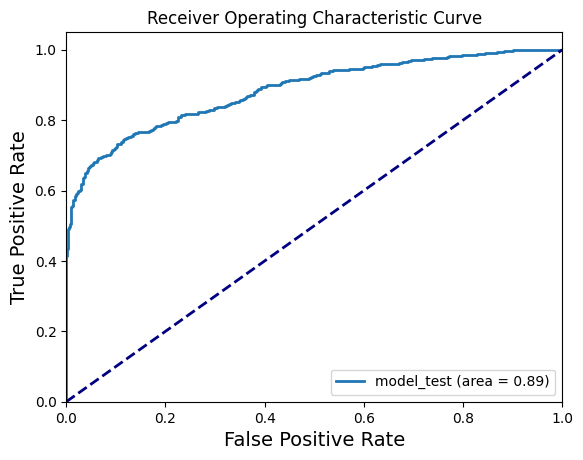

In [ ]:
roc_curve(y_pred, y_label, "model_test.png", "model_test")

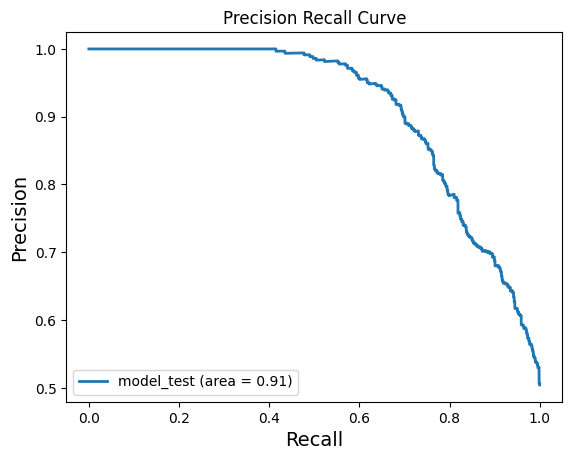

In [ ]:
prauc_curve(y_pred, y_label, "model_test.png", "model_test")

In [ ]:
PATH = '/content/drive/MyDrive/'

torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': opt.state_dict()
}, PATH + 'all.tar')